In [1]:
# trainnig parameters
print_model=0
batch_size = 512  # size of the minibatch for stochastic gradient descent (or Adam)
num_epochs = 20     # number of epochs for training
num_classes = 8       # number of classes. Do not change this
learning_rate =0.05*(0.6)**0  # Learning rate for SGD (or Adam)
weight_decay = 0.001     # regularization. Increase this to combat overfitting
momentum=0.9 
accumulation_steps=2
model_name= "Model1"
suffix=''

### from scratch trainnig

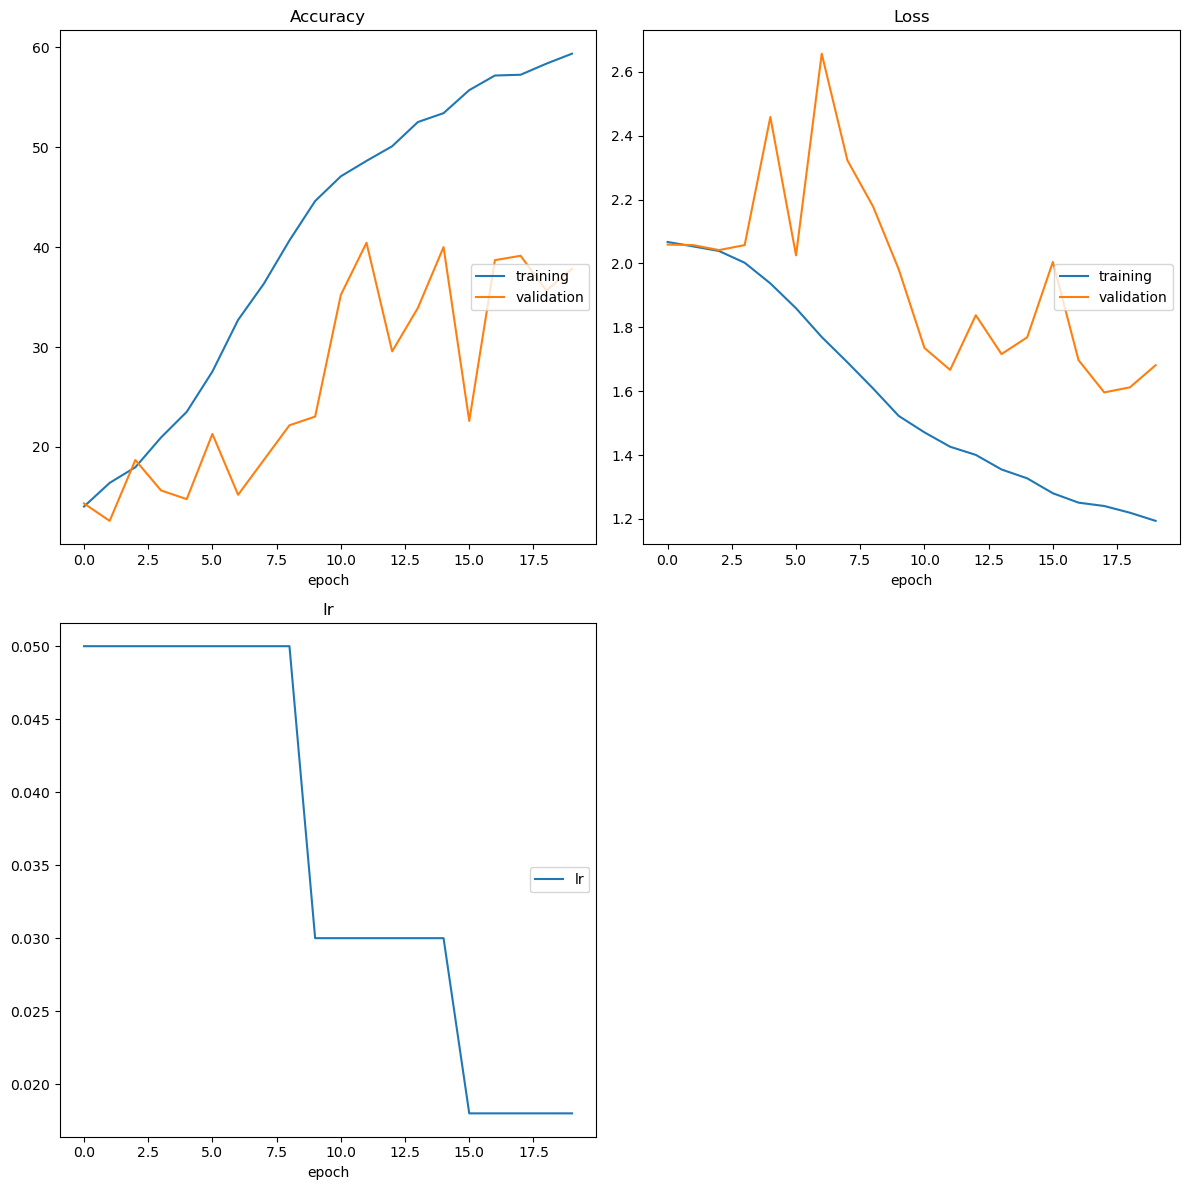

Epoch: 20 	Training Loss: 1.194078 	Validation Loss: 1.681462	Training Acc: 59.352 	Validation Acc: 37.826	Training 5Acc: 94.241 	Validation 5Acc: 87.826


In [2]:

# imports
from src.data import get_data_loaders
from src.train import optimize
from src.helpers import load_model, replace_insatance
import torch.nn.functional as F
import src.models.audio as im_modesl
from torch.optim import lr_scheduler
import torch


data_loaders = get_data_loaders(batch_size=batch_size, is_mel=False)
torch.backends.cuda.matmul.allow_tf32=True
torch.backends.cudnn.allow_tf32=True

model = getattr(im_modesl, model_name)(num_classes=num_classes)
# initialize
def init_weights(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.orthogonal_(m.weight)

model.apply(init_weights)
# Get the optimizer using get_optimizer and the model you just created, the learning rate,
# the optimizer and the weight decay specified in the previous cel
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=momentum,weight_decay=weight_decay,)


#milestones=[5,9,12, *range(12,num_epochs,2)]
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.6, patience=2,threshold=1e-3,verbose=True)
#scheduler = lr_scheduler.ExponentialLR(optimizer,gamma=0.7)

def step(loss ,epoch=None):
    scheduler.step(loss)

def loss(output,target):
    #target=F.one_hot(target, num_classes).float()
    return F.cross_entropy(output, target,label_smoothing=0.03)




s_epoch=load_model(model_name+suffix,model)
if print_model:
    print(f"model {model_name} has :{sum(p.numel() for p in model.parameters())/1e6} M parameters ")
    print(f"Effictive W>0.01 precentage: ")
    print('\n'.join('layer {} has : {}'.format(n,torch.sum(torch.abs(p)>0.01)/p.numel()) for n, p in model.named_parameters()))
#replace_insatance(model,torch.nn.LeakyReLU, models.Swish())
#print(model)

optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    s_epoch=s_epoch,
    n_epochs=num_epochs,
    model_name=model_name+suffix,
    step=step,
    accumulation_steps=accumulation_steps,
    run_logs=False,
    interactive_tracking=True
    
)